# 导入数据及预处理

In [1]:
from data_process.Image_pair_creation import *

X, Y = get_data_from_npy(size=2, total_sample_size=10000)

In [2]:
X.shape

(20000, 2, 1, 56, 46)

In [3]:
X[1,0].shape

(1, 56, 46)

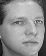

In [4]:
from PIL import Image
your_matrix = np.squeeze(X[1,0])
image = Image.fromarray(np.uint8(your_matrix * 255))
image

In [5]:
Y.shape

(20000, 1)

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

In [7]:
x_train.shape

(15000, 2, 1, 56, 46)

# 网络搭建

In [8]:
from model.network import *

input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [9]:
img_a.shape

TensorShape([None, 1, 56, 46])

In [10]:
input_dim

(1, 56, 46)

In [11]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

In [12]:
feat_vecs_a

<KerasTensor: shape=(None, 50) dtype=float32 (created by layer 'sequential')>

# 距离函数

In [13]:
from distance_function import *
distance = EuclideanDistanceLayer()([feat_vecs_a, feat_vecs_b])

In [14]:
from keras.models import Model
model = Model(inputs=[img_a, img_b], outputs=distance)

# 优化器与损失函数

In [15]:
import tensorflow as tf

def compute_accuracy(predictions, labels):
    predictions = tf.reshape(predictions, [-1])  # 将预测结果展平
    a = tf.reduce_mean(tf.cast(labels[predictions < 0.5], dtype=tf.float32))
    return tf.where(a > 1, tf.ones_like(a), a)

In [16]:
# 优化器
from keras.optimizers import RMSprop

# 损失函数
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [17]:
model.compile(loss=contrastive_loss, optimizer=RMSprop(learning_rate=0.001),
              metrics=[compute_accuracy])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1, 56, 46)]  0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 1, 56, 46)]  0           []                               
                                                                                                  
 sequential (Sequential)        (None, 50)           394046      ['input_1[0][0]',                
                                                                  'input_2[0][0]']                
                                                                                                  
 euclidean_distance_layer (Eucl  (None, 1)           0           ['sequential[0][0]',         

# 模型训练

In [18]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]

In [19]:
img_1.shape

(15000, 1, 56, 46)

In [20]:
history = model.fit([img_1, img2], y_train, validation_split=.2, epochs=15, batch_size=32, verbose=1)

Epoch 1/15
375/375 [==============================] - 7s 8ms/step - loss: 0.2062 - compute_accuracy: 0.6836 - val_loss: 0.2452 - val_compute_accuracy: 0.3280
Epoch 2/15
375/375 [==============================] - 3s 7ms/step - loss: 0.1104 - compute_accuracy: 0.8632 - val_loss: 0.1398 - val_compute_accuracy: 0.5265
Epoch 3/15
375/375 [==============================] - 3s 7ms/step - loss: 0.0724 - compute_accuracy: 0.9547 - val_loss: 0.0700 - val_compute_accuracy: 0.7558
Epoch 4/15
375/375 [==============================] - 3s 8ms/step - loss: 0.0546 - compute_accuracy: 0.9849 - val_loss: 0.0483 - val_compute_accuracy: 0.8521
Epoch 5/15
375/375 [==============================] - 3s 7ms/step - loss: 0.0442 - compute_accuracy: 0.9939 - val_loss: 0.0346 - val_compute_accuracy: 0.9362
Epoch 6/15
375/375 [==============================] - 3s 7ms/step - loss: 0.0378 - compute_accuracy: 0.9961 - val_loss: 0.0286 - val_compute_accuracy: 0.9700
Epoch 7/15
375/375 [==============================] 

# 可视化分析

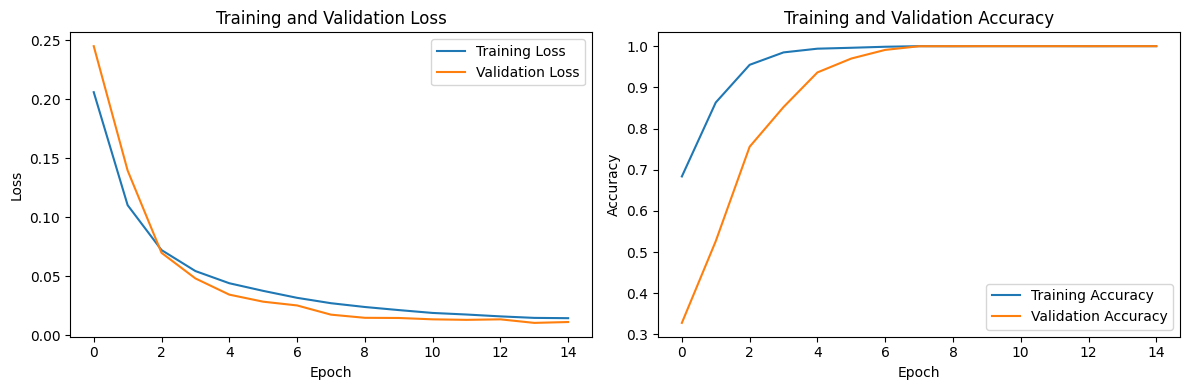

In [21]:
import matplotlib.pyplot as plt

# 画出损失曲线
plt.figure(figsize=(12, 4))

# 画出训练损失
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# 画出准确率曲线
plt.subplot(1, 2, 2)
plt.plot(history.history['compute_accuracy'], label='Training Accuracy')
plt.plot(history.history['val_compute_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
# plt.savefig('/kaggle/working/img.png')
plt.show()

# 训练集测试

In [22]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])
def compute_accuracy_2(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

157/157 [==============================] - 1s 3ms/step


In [23]:
compute_accuracy_2(pred, y_test)

0.9824561403508771